In [1]:
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from scipy import stats
from scipy.stats import probplot, f_oneway

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

import datetime

import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

### 1. Data loading
data source: https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data_first150k.csv

#### Data fields
* id - No
* country - The country that the wine is from
* description - A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
* designation - The vineyard within the winery where the grapes that made the wine are from
* points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for
* price - The cost for a bottle of the wine
* province - The province or state that the wine is from
* region_1 - The wine growing area in a province or state (ie Napa)
* region_2 - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this
* variety - The type of grapes used to make the wine (ie Pinot Noir)
* winery - The winery name

In [2]:
zip_file = 'C:/Users/ASER/1442_8172_bundle_archive.zip'
archive = zipfile.ZipFile(zip_file, 'r')
data_file = archive.open('winemag-data_first150k.csv')
data = pd.read_csv(data_file)
data = data[data.columns[1:]]
data.index.name = 'id'
data.head(2)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
id,,,,,,,,,,
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


#### Data with no information on prices is removed from the dataset

In [3]:
ind = data[data.price.isnull()].index
data = data.drop(ind, axis=0)
print(f'data.shape = {data.shape}')

data.shape = (137235, 10)


In [4]:
X = data.drop('price', axis=1)
y = data[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')

X_train.shape = (102926, 9), y_train.shape = (102926, 1)
X_test.shape = (34309, 9), y_test.shape = (34309, 1)


### 2. Exploratory Data Analysis

### 2.1 Target variable distribution

In [5]:
y_train.price.describe()

count    102926.000000
mean         33.220003
std          36.966944
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

In [6]:
n_zero_price = len(y_train[y_train.price.isnull()])
range_= y_train.price.describe()[-1] - y_train.price.describe()[3]
qtr_1 = y_train.price.describe()[4]
qtr_3 = y_train.price.describe()[-2]
IQR = qtr_3 - qtr_1
outliers = qtr_3 + 1.5 * IQR
outliers_set = y_train[y_train.price > outliers]
outliers_frac = round(len(outliers_set) / len(y_train), 3)


print(f'Mimimum price of the dataset is {y_train.price.describe()[3]}, maximum price - {y_train.price.describe()[-1]}')
print('Price range =', range_)
print(f'Median price = {y_train.price.describe()[5]}, mean = {round(y_train.price.describe()[1], 1)}')
print(f'Prices of 75% of the dataset are below {y_train.price.describe()[-2]}')
print(f'Interquartile range = {IQR}')
print(f'Ourlier prices starts from {outliers}, fraction of outliers in the dataset = {outliers_frac}')

Mimimum price of the dataset is 4.0, maximum price - 2300.0
Price range = 2296.0
Median price = 24.0, mean = 33.2
Prices of 75% of the dataset are below 40.0
Interquartile range = 24.0
Ourlier prices starts from 76.0, fraction of outliers in the dataset = 0.056


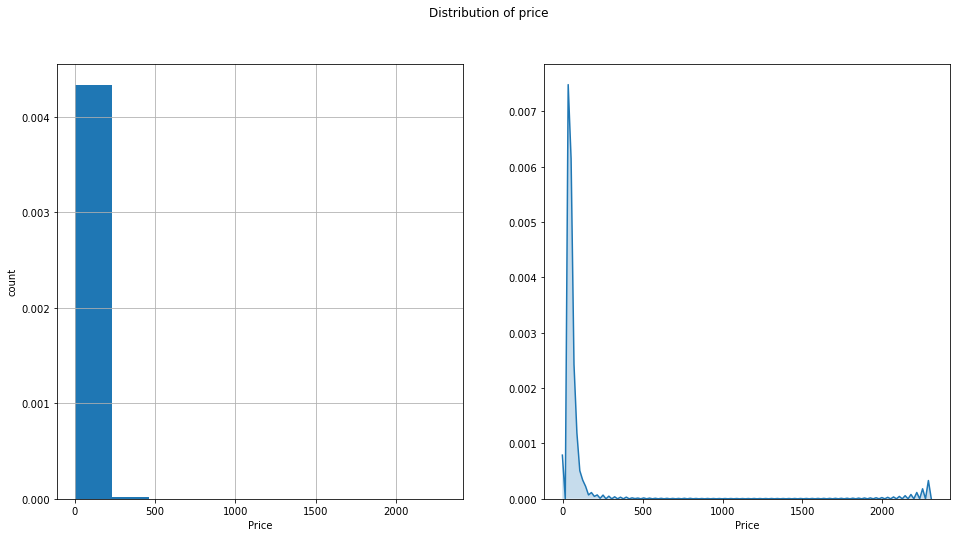

In [7]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
y_train.price.hist(density=True)  # density=True  # shift + Tab = спарвка по функции
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(y_train.price, shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

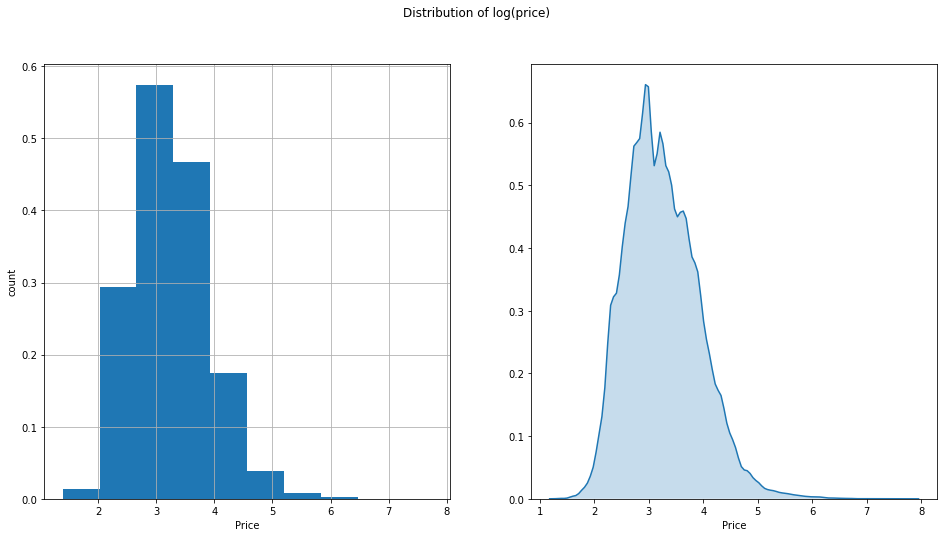

In [8]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
np.log(y_train.price).hist(density=True)  # density=True  # shift + Tab = спарвка по функции
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(np.log(y_train.price), shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of log(price)')
plt.show()

#### Q-Q plot for log(price)

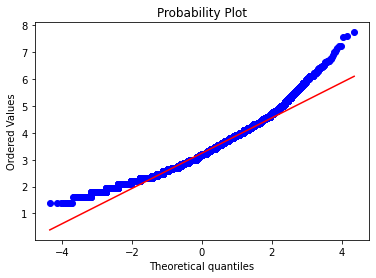

In [9]:
probplot(np.log(y_train.price), dist="norm", plot=pylab)
pylab.show()

#### Normal distribution test for np.log(y_train.price)

In [10]:
loc = np.log(y_train.price).mean()
scale = np.log(y_train.price).std()

for i in range(1, 4):
    true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
    sample_value = ((np.log(y_train.price) >= loc - i * scale) \
                    & (np.log(y_train.price) <= loc + i * scale)).sum() / y_train.shape[0]
        
    print(f'{i} sigma(s)')
    print(f'\ttheoretical:\t{true_value}')
    print(f'\tlog(price):\t{sample_value}')

1 sigma(s)
	theoretical:	0.6826894921370859
	log(price):	0.6651963546625731
2 sigma(s)
	theoretical:	0.9544997361036416
	log(price):	0.9654703379126751
3 sigma(s)
	theoretical:	0.9973002039367398
	log(price):	0.9930824087208285


### 2.2 Feature analysis

In [11]:
X_train.dtypes

country        object
description    object
designation    object
points          int64
province       object
region_1       object
region_2       object
variety        object
winery         object
dtype: object

### A. Numerical variables

#### 2.2.1 Points

In [12]:
X_train.points.describe()

count    102926.000000
mean         87.789567
std           3.224489
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

No of cases with no points specified: 0


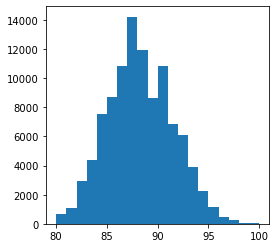

In [13]:
print('No of cases with no points specified:', len(X_train[X_train.points.isnull()]))
X_train.loc[:, 'points'].hist(figsize=(4,4), bins=20, grid=False);

#### Q-Q plot for X_train.points

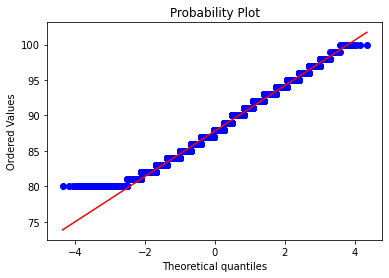

In [14]:
probplot(X_train.points, dist="norm", plot=pylab)
pylab.show()

#### Correlation of points with log(price)

In [15]:
corr = np.corrcoef(X_train.points, np.log(y_train.price))[0][1]
print('Correlation between points and log(price) =', round(corr, 3))

Correlation between points and log(price) = 0.611


#### Joint plot of points and log(price)

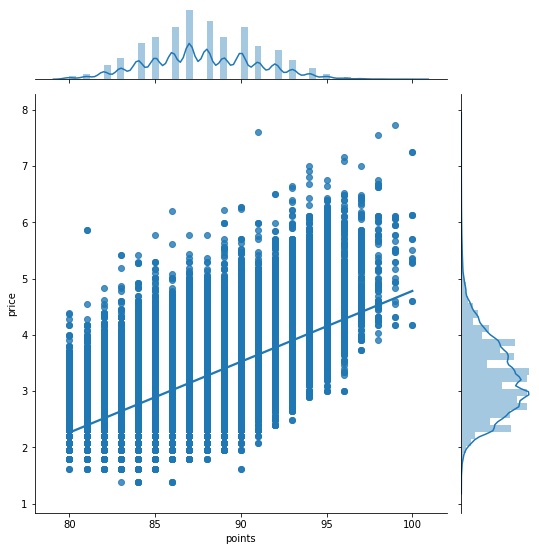

In [16]:
grid = sns.jointplot(X_train.points, np.log(y_train.price), kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

### B. Categorical variables

In [17]:
def ANOVA(categorical_var):
    group_list = X_train[categorical_var].value_counts()
    n_min = 25
    a = [i for i in dict(group_list[group_list > n_min]).keys()]
    df = {}
    df1 = {}
    for i in a:
        group_price_list = y_train[X_train[categorical_var] == i].price.values
        group_mean_price = y_train[X_train[categorical_var] == i].price.mean()
        group_observations_n = len(y_train[X_train[categorical_var] == i])

        df[i] = group_mean_price, group_observations_n
        df1[i] = group_price_list, group_mean_price

    y_all_groups = []
    for item in df1.values():
        y_all_groups = np.concatenate([y_all_groups, item[0]])
    y_mean = y_all_groups.mean()

    SS_b = 0
    n_all_groups = 0
    for group_mean, n in df.values():
        SS_b += n * (group_mean - y_mean) ** 2
        n_all_groups += n

    SS_w = 0
    for group_values, group_mean in df1.values():
        SS_w += ((group_values - group_mean) **2 ).sum()

    k = len(df)
    k1 = k - 1
    k2 = n_all_groups - k

    sigma2_b = SS_b / k1
    sigma2_w = SS_w / k2

    F = sigma2_b / sigma2_w

    alpha = 0.05
    t = stats.f.ppf(1 - alpha, k1, k2)
    
    text_adj = dict({'country': 'countries', 'designation': 'designations', 
                     'province': 'provinces', 'region_1': 'regions in region_1', 
                     'region_2': 'regions in region_2',
                     'variety': 'varieties', 'winery': 'wineries'})
    
    print(f'nummber of {text_adj[categorical_var]} = {X_train[categorical_var].nunique()}')
    print(f'number of cases with no {categorical_var} specified: {len(X_train[X_train[categorical_var].isnull()])}')
    print(f'number of {text_adj[categorical_var]} with more than {n_min} observations = {len(df)}')
    print(f"F-test statistic = {round(F, 3)},  Student's t statistic = {round(t,3)}")
    
    if F > t:
        print(f'Variance of mean prices by {categorical_var} is statistically significant')
    else:
        print(f'Variance of mean prices by {categorical_var} is statistically insignificant')
    
    df = pd.DataFrame(df).T
    df.columns = ['mean_price', 'n_observations']
    df = df.sort_values(by=['mean_price'], ascending=False)
    
    return df

#### 2.2.2 Countries

In [18]:
df = ANOVA('country')

nummber of countries = 45
number of cases with no country specified: 5
number of countries with more than 25 observations = 27
F-test statistic = 136.54,  Student's t statistic = 1.496
Variance of mean prices by country is statistically significant


#### Mean prices and number of observations by country

In [19]:
df.head(10)

,mean_price,n_observations
France,46.083574,11080.0
Hungary,42.674033,181.0
Germany,39.102724,1762.0
Italy,37.677535,13986.0
Canada,34.221477,149.0
US,33.650682,46691.0
Israel,31.790948,464.0
Austria,31.622601,1876.0
Australia,31.421110,3676.0
Mexico,31.200000,45.0


In [20]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
US,33.650682,46691.0
Italy,37.677535,13986.0
France,46.083574,11080.0
Spain,27.240598,6089.0
Chile,19.164141,4356.0
Argentina,20.964115,4180.0
Australia,31.421110,3676.0
Portugal,26.371938,3143.0
New Zealand,24.316631,2315.0
Austria,31.622601,1876.0


#### 2.2.3 Designations

In [21]:
df = ANOVA('designation')

nummber of designations = 24792
number of cases with no designation specified: 31815
number of designations with more than 25 observations = 139
F-test statistic = 26.91,  Student's t statistic = 1.207
Variance of mean prices by designation is statistically significant


In [22]:
df.head(10)

,mean_price,n_observations
Cannubi,93.212121,33.0
Les Clos Grand Cru,87.076923,26.0
Vintage,72.805195,77.0
Stagecoach Vineyard,63.758065,62.0
Pisoni Vineyard,63.000000,26.0
Lewis Vineyard,59.592593,27.0
Blanc de Blancs Brut,57.906977,43.0
Premier Cru,57.114286,35.0
Monte Rosso Vineyard,56.192308,26.0
Red Wine,55.205882,68.0


In [23]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Reserve,33.307617,2035.0
Reserva,18.613414,1327.0
Estate,32.470093,1187.0
Riserva,54.594037,436.0
Brut,30.789100,422.0
Crianza,17.561644,365.0
Estate Grown,35.105740,331.0
Estate Bottled,28.076412,301.0
Dry,16.267176,262.0
Old Vine,21.960474,253.0


#### 2.2.4 Provinces

In [24]:
df = ANOVA('province')

nummber of provinces = 428
number of cases with no province specified: 5
number of provinces with more than 25 observations = 140
F-test statistic = 79.771,  Student's t statistic = 1.205
Variance of mean prices by province is statistically significant


In [25]:
df.head(10)

,mean_price,n_observations
Champagne,92.967312,826.0
Burgundy,71.149536,2481.0
Rheingau,71.011364,264.0
Tokaji,65.228070,57.0
Port,53.733471,484.0
Rhône Valley,50.610278,934.0
Tokaj,49.307692,26.0
Tuscany,48.447529,4431.0
Wachau,47.875000,256.0
Villány,46.292683,41.0


In [26]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
California,35.515805,33280.0
Washington,29.378375,7334.0
Tuscany,48.447529,4431.0
Northern Spain,30.688999,3627.0
Mendoza Province,20.992666,3545.0
Oregon,33.982430,3415.0
Burgundy,71.149536,2481.0
Veneto,32.825011,2303.0
South Australia,35.742348,2189.0
Piedmont,46.238139,2171.0


#### 2.2.5 Region 1 & region 2

In [27]:
df = ANOVA('region_1')

nummber of regions in region_1 = 1155
number of cases with no region_1 specified: 17191
number of regions in region_1 with more than 25 observations = 373
F-test statistic = 71.046,  Student's t statistic = 1.124
Variance of mean prices by region_1 is statistically significant


In [28]:
df.head(10)

,mean_price,n_observations
Pauillac,175.380282,71.0
Côte Rôtie,154.869565,46.0
Corton-Charlemagne,153.933333,30.0
Pessac-Léognan,144.506173,81.0
Hermitage,139.633028,109.0
Pomerol,109.242424,33.0
Vosne-Romanée,103.736842,38.0
Clarendon,101.217391,46.0
Puligny-Montrachet,100.478723,94.0
Rutherglen,99.357143,42.0


In [29]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Napa Valley,49.258562,4672.0
Columbia Valley (WA),26.380467,3727.0
Mendoza,19.501117,2686.0
Russian River Valley,37.682074,2661.0
California,14.956174,2624.0
Paso Robles,29.967206,2287.0
Willamette Valley,32.491677,1562.0
Rioja,34.424735,1415.0
Sonoma County,28.245014,1404.0
Toscana,57.539200,1250.0


In [30]:
df = ANOVA('region_2')

nummber of regions in region_2 = 18
number of cases with no region_2 specified: 57318
number of regions in region_2 with more than 25 observations = 18
F-test statistic = 503.575,  Student's t statistic = 1.623
Variance of mean prices by region_2 is statistically significant


In [31]:
df.head(10)

,mean_price,n_observations
Napa,53.939440,6605.0
South Coast,37.296774,155.0
Willamette Valley,36.499576,2356.0
Sonoma,36.371877,8406.0
Napa-Sonoma,35.668285,1236.0
Central Coast,31.720112,9686.0
Columbia Valley,29.649840,6894.0
Mendocino/Lake Counties,29.192371,1809.0
Oregon Other,27.683128,486.0
North Coast,26.649378,482.0


In [32]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Central Coast,31.720112,9686.0
Sonoma,36.371877,8406.0
Columbia Valley,29.649840,6894.0
Napa,53.939440,6605.0
California Other,15.025872,2667.0
Willamette Valley,36.499576,2356.0
Mendocino/Lake Counties,29.192371,1809.0
Napa-Sonoma,35.668285,1236.0
Sierra Foothills,24.916396,1232.0
Finger Lakes,19.395944,1134.0


#### 2.2.6 Varieties

In [33]:
df = ANOVA('variety')

nummber of varieties = 592
number of cases with no variety specified: 0
number of varieties with more than 25 observations = 154
F-test statistic = 62.24,  Student's t statistic = 1.195
Variance of mean prices by variety is statistically significant


In [34]:
df.head(10)

,mean_price,n_observations
Tinto Fino,86.163934,61.0
Champagne Blend,78.325490,765.0
Tokaji,73.114754,61.0
Nebbiolo,67.369838,1114.0
Tinto del Pais,61.387097,62.0
Cabernet Blend,60.636771,223.0
Sangiovese Grosso,60.426883,677.0
Spätburgunder,59.225000,40.0
Marsanne,54.802083,96.0
Sagrantino,51.134328,67.0


In [35]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Chardonnay,32.307857,10271.0
Pinot Noir,44.128055,10230.0
Cabernet Sauvignon,42.125482,9595.0
Red Blend,35.742906,6978.0
Sauvignon Blanc,18.617451,4504.0
Syrah,36.932301,4328.0
Riesling,29.824131,3912.0
Merlot,27.424833,3745.0
Bordeaux-style Red Blend,49.474934,3411.0
Zinfandel,26.637359,2832.0


#### 2.2.7 Wineries

In [36]:
df = ANOVA('winery')

nummber of wineries = 12961
number of cases with no winery specified: 0
number of wineries with more than 25 observations = 871
F-test statistic = 25.846,  Student's t statistic = 1.081
Variance of mean prices by winery is statistically significant


In [37]:
df.head(10)

,mean_price,n_observations
Tenuta dell'Ornellaia,254.615385,26.0
Domaine Leflaive,225.870968,31.0
Perrier Jouët,184.892857,28.0
Robert Weil,176.875000,32.0
Le Macchiole,162.400000,35.0
M. Chapoutier,138.833333,54.0
Emilio Moro,131.363636,33.0
E. Guigal,126.771930,57.0
Bouchard Père & Fils,125.523810,147.0
Tua Rita,120.620690,29.0


In [38]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Williams Selyem,57.417857,280.0
Testarossa,48.556604,212.0
DFJ Vinhos,9.972973,185.0
Chateau Ste. Michelle,22.244318,176.0
Kendall-Jackson,29.235294,170.0
Columbia Crest,16.939759,166.0
Concha y Toro,28.138554,166.0
De Loach,32.846667,150.0
Trapiche,25.315436,149.0
Joseph Drouhin,84.459459,148.0


### 3. Feature engineering

In [39]:
class FeatureGenetator():
    """Generation of new features"""
    
    def __init__(self):
        self.countries_counts = None
        self.designations_counts = None
        self.provinces_counts = None
        self.region_1_counts = None
        self.region_2_counts = None
        self.varieties_counts = None
        self.wineries_counts = None        
        
        self.med_price_by_country = None
        self.med_price_by_designation = None
        self.med_price_by_province = None
        self.med_price_by_region = None        
        self.med_price_by_variety = None
        self.med_price_by_winery = None       
               
        
    def fit(self, X, y=None):        
        X = X.copy()
        min_n = 25
        
        # Countries
        countries = X.country.value_counts()
        countries = countries[countries > min_n]                
        self.countries_counts = dict(countries)
        
        # Designations
        designations = X.designation.value_counts()
        designations = designations[designations > min_n]                
        self.designations_counts = dict(designations)        
                
        # Provinces
        provinces = X.province.value_counts()
        provinces = provinces[provinces > min_n]                
        self.provinces_counts = dict(provinces)
        
        # Region_1
        region_1 = X.region_1.value_counts()
        region_1 = region_1[region_1 > min_n]                
        self.region_1_counts = dict(region_1)
        
        # Region_2
        region_2 = X.region_2.value_counts()
        region_2 = region_2[region_2 > min_n]                
        self.region_2_counts = dict(region_2)
        
        # Varieties
        varieties = X.variety.value_counts()
        varieties = varieties[varieties > min_n]                
        self.varieties_counts = dict(varieties)
        
        # Wineries
        wineries = X.winery.value_counts()
        wineries = wineries[wineries > min_n]                
        self.wineries_counts = dict(wineries)
        
        # Target encoding
        ## 1. Countries
        df = X.copy()
        
        if y is not None:
            df['price'] = y.values            
            df['countries_popular'] = df['country'].copy()
            df.loc[~df['countries_popular'].isin(countries.keys().tolist())] = np.nan
            
            self.med_price_by_country = df.groupby(['countries_popular'], 
                                                    as_index=False).agg({'price':'median'}).\
                                            rename(columns={'price':'MedPriceByCountry',
                                                           'countries_popular': 'country'})            
        ## 2. Designations    
        if y is not None:
            df['price'] = y.values            
            df['designations_frequent'] = df['designation'].copy()
            df.loc[~df['designations_frequent'].isin(designations.keys().tolist())] = np.nan
            
            self.med_price_by_designation = df.groupby(['designations_frequent'], 
                                                     as_index=False).agg({'price':'median'}).\
                                            rename(columns={'price':'MedPriceByDesignation',
                                                           'designations_frequent': 'designation'})            
        ## 3. Provinces    
        if y is not None:
            df['price'] = y.values            
            df['provinces_popular'] = df['province'].copy()
            df.loc[~df['provinces_popular'].isin(provinces.keys().tolist())] = np.nan
            
            self.med_price_by_province = df.groupby(['provinces_popular'], 
                                                     as_index=False).agg({'price':'median'}).\
                                            rename(columns={'price':'MedPriceByProvince',
                                                           'provinces_popular': 'province'})            
        ## 4. Regions    
        if y is not None:
            df['price'] = y.values            
            df['region_1_popular'] = df['region_1'].copy()
            df['region_2_popular'] = df['region_2'].copy()
            df.loc[~df['region_1_popular'].isin(region_1.keys().tolist())] = np.nan
            df.loc[~df['region_2_popular'].isin(region_2.keys().tolist())] = np.nan
            
            self.med_price_by_region = df.groupby(['region_1_popular', 'region_2_popular'], 
                                                     as_index=False).agg({'price':'median'}).\
                                            rename(columns={'price':'MedPriceByRegion',
                                                           'region_1_popular': 'region_1',
                                                           'region_2_popular': 'region_2'})            
        ## 5. Varieties    
        if y is not None:
            df['price'] = y.values            
            df['varieties_popular'] = df['variety'].copy()
            df.loc[~df['varieties_popular'].isin(varieties.keys().tolist())] = np.nan
            
            self.med_price_by_variety = df.groupby(['varieties_popular'], 
                                                     as_index=False).agg({'price':'median'}).\
                                            rename(columns={'price':'MedPriceByVariety',
                                                           'varieties_popular': 'variety'})            
        ## 6. Wineries   
        if y is not None:
            df['price'] = y.values            
            df['wineries_popular'] = df['winery'].copy()
            df.loc[~df['wineries_popular'].isin(wineries.keys().tolist())] = np.nan
            
            self.med_price_by_winery = df.groupby(['wineries_popular'], 
                                                     as_index=False).agg({'price':'median'}).\
                                            rename(columns={'price':'MedPriceByWinery',
                                                           'wineries_popular': 'winery'})            
    
    def transform(self, X):       
        
        # Target encoding
        if self.med_price_by_country is not None:
            X = X.merge(self.med_price_by_country, on=['country'], how='left')
            
        if self.med_price_by_designation is not None:
            X = X.merge(self.med_price_by_designation, on=['designation'], how='left')
        
        if self.med_price_by_province is not None:
            X = X.merge(self.med_price_by_province, on=['province'], how='left')
            
        if self.med_price_by_region is not None:
            X = X.merge(self.med_price_by_region, on=['region_1', 'region_2'], how='left')
            
        if self.med_price_by_variety is not None:
            X = X.merge(self.med_price_by_variety, on=['variety'], how='left')
        
        if self.med_price_by_winery is not None:
            X = X.merge(self.med_price_by_winery, on=['winery'], how='left')
            
        
        # More categorical features
        X = self.points_group(X)        
        
        # Dummy variables
        X = self.get_dummies(X)        
        
        # PCA variables
        X = self.pca_features(X)
        
        
        return X
            
    @staticmethod
    def points_group(X):        
        X['points_group'] = np.nan        
        X.loc[X['points'] <= 86, 'points_group'] = 1  
        X.loc[(X['points'] >= 87) & (X['points'] <= 88), 'points_group'] = 2
        X.loc[(X['points'] >= 89) & (X['points'] <= 90), 'points_group'] = 3
        X.loc[(X['points'] >= 91) & (X['points'] <= 95), 'points_group'] = 4
        X.loc[X['points'] >= 96, 'points_group'] = 5
        
        return X
    
    @staticmethod    
    def get_dummies(X):
        ## Points            
        a = pd.get_dummies(X.points_group).rename(columns={1: 'PG_1', 2: 'PG_2', 3: 'PG_3', 4: 'PG_4', 5: 'PG_5'})
        X = pd.concat([X, a], axis=1)       
    
  
        ## clustered 'MedPriceByCountry', 'MedPriceByDesignation', 'MedPriceByProvince', 
        ##           'MedPriceByRegion', 'MedPriceByVariety', 'MedPriceByWinery'
        scaler = StandardScaler()
        a = X[['MedPriceByRegion', 'MedPriceByVariety', 'MedPriceByWinery']].fillna(0)
        a = scaler.fit_transform(a)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(a)
        X.loc[:, 'Cluster_composit'] = kmeans.labels_
        
        a = pd.get_dummies(X.Cluster_composit).rename(columns={0: 'Cluster_1', 1: 'Cluster_2'})
        X = pd.concat([X, a], axis=1).drop('Cluster_composit', axis=1)
        
        return X
    
    @staticmethod   
    def pca_features(X):
        scaler = StandardScaler()
        a = X[['MedPriceByCountry', 'MedPriceByProvince', 'MedPriceByRegion', 
               'MedPriceByVariety', 'MedPriceByWinery']].fillna(0)
        
        a = scaler.fit_transform(a)        
        pca = PCA(n_components=3)
        pca.fit(a)        
        X.loc[:, 'pca_composit_1'] = np.dot(a, pca.components_.T)[:, 0]
        X.loc[:, 'pca_composit_2'] = np.dot(a, pca.components_.T)[:, 1]
        X.loc[:, 'pca_composit_3'] = np.dot(a, pca.components_.T)[:, 2]        
    
        return X

In [40]:
features = FeatureGenetator()
features.fit(X_train, y_train)

X_train = features.transform(X_train)
X_test = features.transform(X_test)

In [41]:
X_train.columns

Index(['country', 'description', 'designation', 'points', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'MedPriceByCountry',
       'MedPriceByDesignation', 'MedPriceByProvince', 'MedPriceByRegion',
       'MedPriceByVariety', 'MedPriceByWinery', 'points_group', 'PG_1', 'PG_2',
       'PG_3', 'PG_4', 'PG_5', 'Cluster_1', 'Cluster_2', 'pca_composit_1',
       'pca_composit_2', 'pca_composit_3'],
      dtype='object')

### 4. Target encoded variables analysis - numeric variables

### 4.A Analysis of dependence of target on target encoded variables
#### Correlations between the target and each of the target encoded variables

In [42]:
var_list = ['MedPriceByVariety','MedPriceByProvince', 'MedPriceByCountry', 
            'MedPriceByRegion', 'MedPriceByWinery', 'MedPriceByDesignation',
            'pca_composit_1', 'pca_composit_2', 'pca_composit_3']

print('Correlation between log(price) and target encoded variable:')
for var in var_list:
    corr = np.corrcoef(X_train[var].fillna(0), np.log(y_train.price))[0][1]
    if var[:3] == 'pca':
        print(f'{var}:\t\t {round(corr, 3)}')
    else:
        print(f'{var}:\t {round(corr, 3)}')

Correlation between log(price) and target encoded variable:
MedPriceByVariety:	 0.307
MedPriceByProvince:	 0.304
MedPriceByCountry:	 0.272
MedPriceByRegion:	 0.254
MedPriceByWinery:	 0.147
MedPriceByDesignation:	 0.038
pca_composit_1:		 0.371
pca_composit_2:		 -0.165
pca_composit_3:		 0.064


### 4.B Normality tests

In [43]:
def norm_test1(keys):
    fig, axes = plt.subplots(ncols=len(keys))
    fig.set_size_inches(4 * len(keys), 4)
    axes = axes.flatten()

    for key, ax in zip(keys, axes):
        ax.hist(X_train[key], density=True)

        loc = X_train[key].mean()
        scale = X_train[key].std()

        x_left, x_right = ax.get_xlim()
        x = np.linspace(x_left, x_right, 10000)
        y = stats.norm.pdf(x, loc=loc, scale=scale)

        ax.plot(x, y, linestyle='dashed')
        ax.set_title(key)
        
def norm_test2(keys):
    fig, axes = plt.subplots(ncols=len(keys))
    fig.set_size_inches(4 * len(keys), 4)
    axes = axes.flatten()

    for key, ax in zip(keys, axes):
        samples = X_train[key]

        loc = samples.mean()
        scale = samples.std()

        interval = np.linspace(0, 1, samples.shape[0])[1:-1]
        x = stats.norm.ppf(interval, loc=loc, scale=scale)
        y = np.quantile(samples, interval)

        ax.scatter(x, y, s=5)
        ax.plot(x, x, color='C1', linestyle='dashed')

        ax.set_title(key)
        ax.set_xlabel('theoretical quantiles')
        ax.set_ylabel('sample quantiles')
        
def norm_test3(keys):
    for key in keys:
        print(key)

        samples = X_train[key]

        loc = samples.mean()
        scale = samples.std()

        for i in range(1, 4):
            true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
            sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]

            print(f'{i} sigma(s)')
            print(f'\ttheoretical:\t{true_value}')
            print(f'\tsample:\t\t{sample_value}')

        print()    

#### Normality tests of pca_composit variables

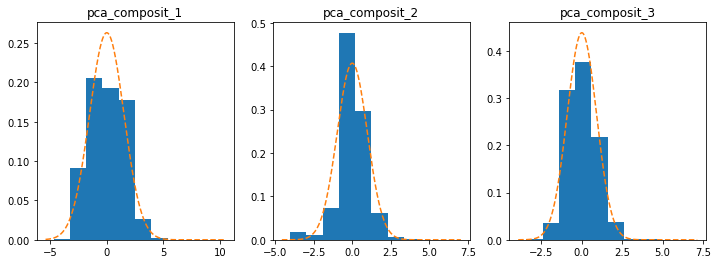

In [44]:
keys = ['pca_composit_1', 'pca_composit_2', 'pca_composit_3']
norm_test1(keys)

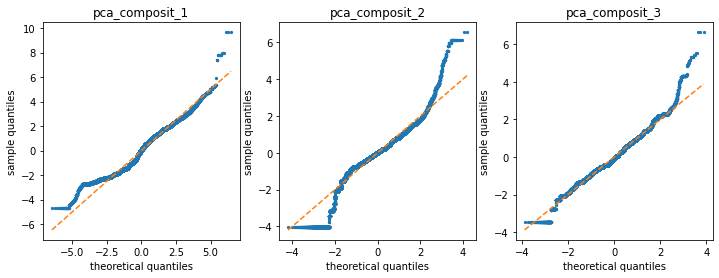

In [45]:
norm_test2(keys)

In [46]:
norm_test3(keys)

pca_composit_1
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6048714610496861
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9842508209781785
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9983386122068282

pca_composit_2
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7817752560091716
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9549967938130307
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9768182966403047

pca_composit_3
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6967238598604822
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9492548044225949
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9953364553174125



#### Normality tests of other numeric target encoded variables 

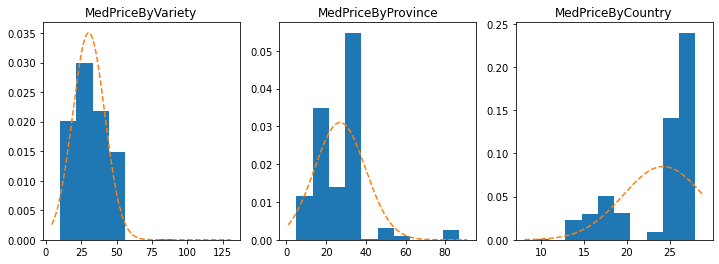

In [47]:
keys = ['MedPriceByVariety','MedPriceByProvince', 'MedPriceByCountry']
norm_test1(keys)

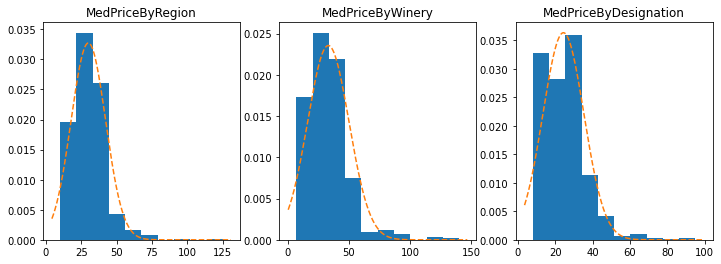

In [48]:
keys = ['MedPriceByRegion', 'MedPriceByWinery', 'MedPriceByDesignation']
norm_test1(keys)

### 4.C Correlation matrix of numeric target encoded variables

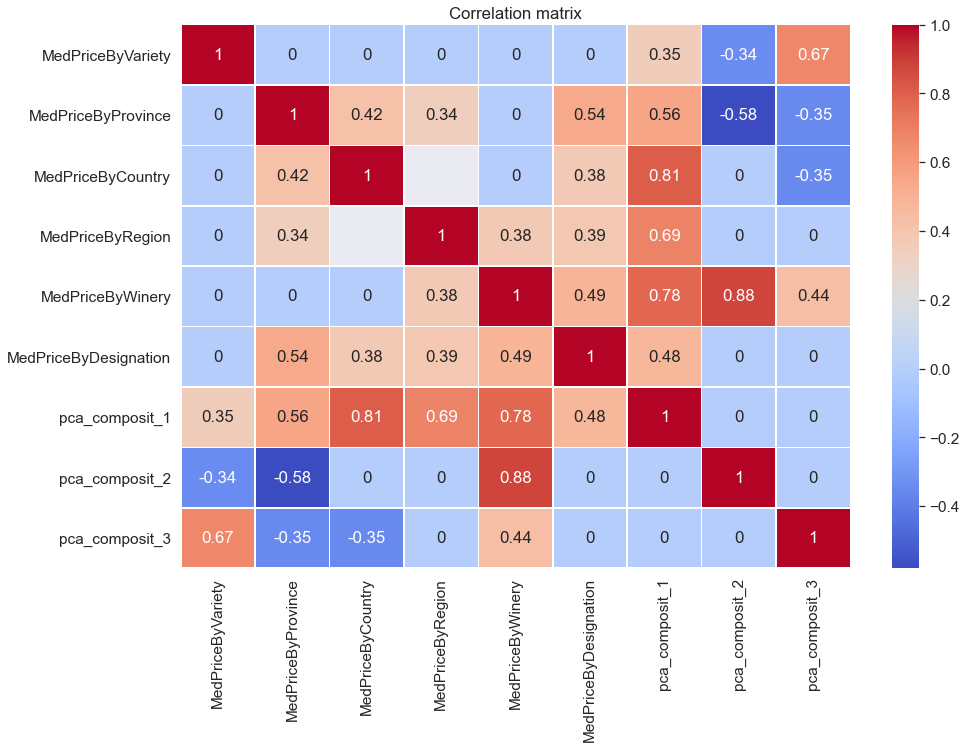

In [49]:
df = X_train[var_list]
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### 5. Target encoded variables analysis - categorical / binary variables

#### 5.1 Categorical variable points_group

Correlation between points and points_group:

                 points  points_group
points        1.000000      0.937017
points_group  0.937017      1.000000



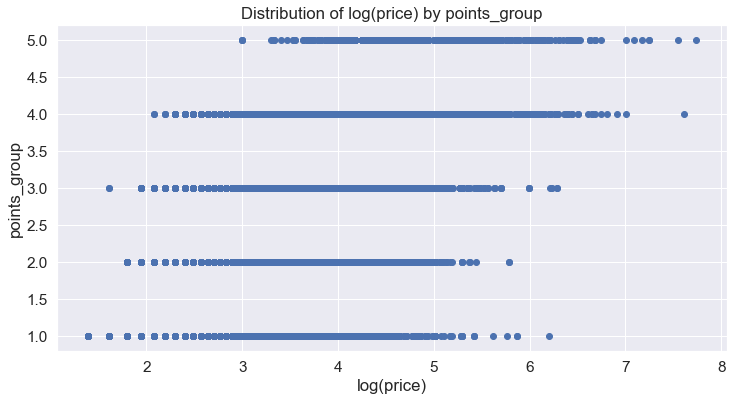

In [50]:
print(f"Correlation between points and points_group:\n\n {X_train[['points', 'points_group']].corr()}\n")
plt.figure(figsize=(12, 6))
plt.scatter(np.log(y_train['price']), X_train['points_group'])

plt.xlabel('log(price)')
plt.ylabel('points_group')
plt.title('Distribution of log(price) by points_group')
plt.show()

In [51]:
def binary_var(var_name):
    counts = X_train[var_name].value_counts()

    plt.figure(figsize=(6,4))    
    plt.title(var_name)
    sns.barplot(counts.index, counts.values)

    plt.show()

#### 5.2 Binary variables PG_1, PG_2, PG_3, PG_4, PG_5

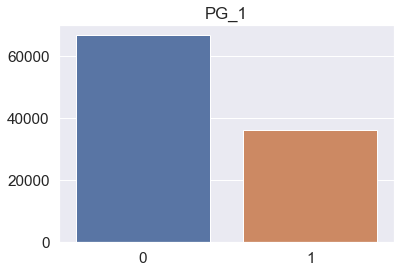

In [52]:
binary_var('PG_1')

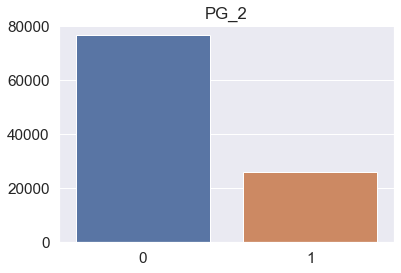

In [53]:
binary_var('PG_2')

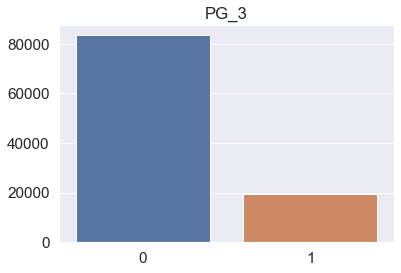

In [54]:
binary_var('PG_3')

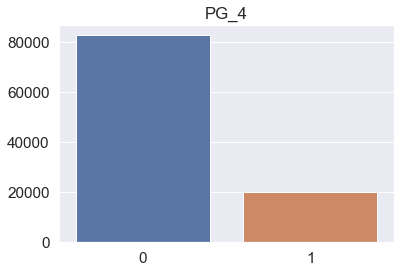

In [55]:
binary_var('PG_4')

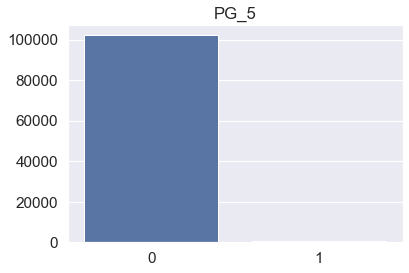

In [56]:
binary_var('PG_5')

#### 5.3 Binary variables Cluster_1, Cluster_2

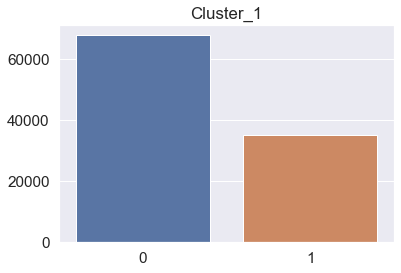

In [57]:
binary_var('Cluster_1')

### 6. Selection of variables for linear regression

Although linear regression is not the best fit for our dataset, to compare the results generated by linear regression vs the ones of non-linear models (LGBMRegressor, RandomForestRegressor, VotingRegressor), here we select variables for linear regression.

Distribution of points and pca_composit variables is more or less close to normal. All 4 variables have low correlation between each other and acceptable correlation with the target (0.611, 0.371, -0.165 and 0.064 correspondingly).

Distributions of two other numerical target encoded variables - MedPriceByProvince and MedPriceByCountry significantly departs from normal. Another pair - MedPriceByWinery and MedPriceByDesignation has low correlation with the target (0.147 and 0.038 correspondingly). We should also notice that MedPriceByWinery is strongly correlated with pca_composit_1 and pca_composit_2 (0.78 and 0.88) - another argument for rejection. To address multicollinearity problem, we should also reject MedPriceByVariety and  MedPriceByRegion. They are highly correlated with pca_composit variables (0.67 and 0.69 correspondingly).

Categorical variable points_group looks promising but it is highly correlated with points (corr = 0.937). So, between two of them points has been chosen as the more informative.Among 5 binary variables PG1, PG_2, PG_3, PG_4 and PG_5, PG_1 is too large to influence the target while PG_5 does not contain enough observations. Binary variable Cluster_1 is added to the list.

So, the final selection:
['points', 'pca_composit_1', 'pca_composit_2', 'pca_composit_3', 'PG_2', 'PG_3', 'PG_4', 'Cluster_1']

In [58]:
var_list = ['points', 'pca_composit_1', 'pca_composit_2','pca_composit_3',            
           'PG_2', 'PG_3', 'PG_4', 'Cluster_1']

model = LinearRegression().fit(X_train[var_list].fillna(0), np.log(y_train))

r2 = model.score(X_train[var_list].fillna(0), np.log(y_train.price))
print(f'The coefficient of determination = {r2}')

n = X_train.shape[0]
p = len(var_list) + 1
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted coefficient of determination = {r2_adj}')

The coefficient of determination = 0.46923451169935076
Adjusted coefficient of determination = 0.46918809627905944


#### Statistical analysis of the regression equation

In [59]:
k1 = len(var_list)
k2 = n - k1 - 1
F = (r2 / k1) / ((1 - r2) / k2)

alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)
print(f"F-test statistic = {round(F, 3)}, Student's t statistic = {round(t, 3)}.")
print('The regression equation is statistically significant')

F-test statistic = 11373.245, Student's t statistic = 1.939.
The regression equation is statistically significant


Mean of residuals = -6.774139285521188


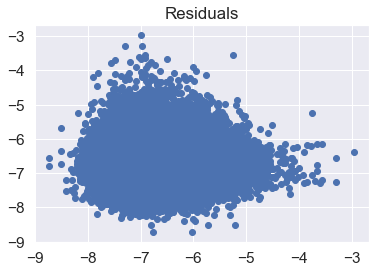

In [61]:
b = model.coef_[0]
X_linear = np.array(X_train[var_list].fillna(0))
y_pred = X_linear.dot(b)

e = np.log(y_train.price) - y_pred
print(f'Mean of residuals = {e.mean()}')
plt.scatter(e[1:],e[:-1])
plt.title('Residuals')
plt.show()

#### Q-Q plot for residuals

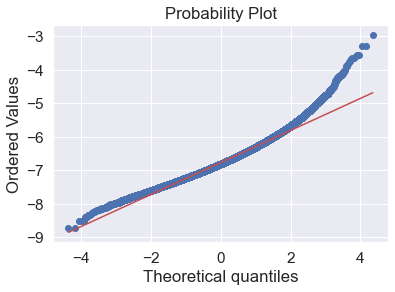

In [62]:
probplot(e, dist="norm", plot=pylab)
pylab.show()